In [1]:
%matplotlib notebook

from sympy import *
from modsim import *

In [64]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian

In [65]:
x_sym = symbols('x_sym')

In [66]:
# Condition with no drag and no friction
condition = Condition(g = 9.8 * m/s**2,
                     point_a = (0.0 * m, 3.0 * m),
                     point_b = (3.0 * m, 0.0 * m),
                     length = .15 * m,
                     width = .15* m,
                     height = .15 * m,
                     rho = 1.225 *kg/m**3,
                     C_d = .8,
                     C_f = .6,
                     density = 1920 * kg/m**3)

In [80]:
def make_system_linear(condition=condition, a=None, b=None):
    unpack(condition)
    
    mass= length*width*height*density
    
    if b is None:
        b = point_a[1]
        
    if a is None:
        # If there is no ramp_func, make a linear one connecting A and B
        # f(x) = a*x + b
        a = (point_a[1] - point_b[1])/(point_a[0] - point_b[0])
        
    ramp_func = linear_func(x_input=0, a=a, b=b)
    init = State(x=point_a[0], y=point_a[1], v=0 * m / s)
    system = System(init=init, condition=condition, ramp_func=ramp_func, a=a, b=b, t0=0, dt=0.01 *s)
    return system

In [81]:
def linear_func(x_input, a, b):
    """
    f(x) = a*x_sym + b
    x from 0 to infinity
    returns: function f(x_sym) at x = x_threshold
    """
    if x_input < -b / a:
        return x_sym * a + b
    else: 
        return 0 

In [8]:
def quadratic_func(a, b, c):
    """
    f(x) = a*x_sym^2 + b*x_sym + c
    x from 0 to infinity
    returns: function f(x_sym) at x = x_threshold
    """
    return a*x_sym**2 + b*x_sym + c

In [9]:
def dif(function):
    """
    Differentiate a function f(x), must have x_sym in the function
    """
    return diff(function)

In [82]:
def update_func(system):
    #unpack(system)
    
    # Find direction of v based on ramp_func slope at x
    system.ramp_func = linear_func(system.x, system.a, system.b)
    system.ramp_dif = dif(system.ramp_func)

    slope_a = system.ramp_dif.subs(x_sym, system.x)      #expr.subs= subsitute(x,y) substitutes y for x in expr
   
    alpha = sympy.atan(slope_a)                          # alpha = angle of slope    
    
    # Find magnitude of v based on acceleration/gravity
    
    a_g = system.condition.g * sympy.sin(alpha)
    a_f = C_f * m * system.condition.g * sympy.cos(alpha)
    a_d = 1/2 * rho * c_d * length * width * system.v**2
    
    acceration = a_f + a_d - a_g 
    
#     acceration = -system.condition.g * sympy.sin(alpha)
    system.v = system.v + acceration * system.dt
    
#     a_x =
#     a_y =
    
#     v_x = 
    # Find v_x and v_y from v_direction and magnitude
    v_x = system.v * sympy.cos(alpha)                   # multiply velocity by angle to get horizontal
    v_y = system.v * sympy.sin(alpha)                   #
    
    system.x = system.x + v_x * system.dt
    system.y = system.y + v_y * system.dt

    return State(x=system.x, y=system.y, v=system.v)

In [83]:
def run_simulation(system, update_func):    
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init

    system.t = system.t0
    system.x = system.init.x
    system.y = system.init.y
    system.v = system.init.v
    
    while system.x < system.condition.point_b[0]:
        system.t += system.dt                              # add dt to time               
        frame.loc[system.t] = update_func(system)          # running update_func and asign to frame location
        
    system.results = frame

In [85]:
# Best in theory = system_0
system_0 = make_system_linear(condition=condition, a=-sqrt(3), b=3)
system_1 = make_system_linear(condition=condition, b=3)
system_2 = make_system_linear(condition=condition, a=-4, b=3)

run_simulation(system_0, update_func)
run_simulation(system_1, update_func)
run_simulation(system_2, update_func)

ValueError: Cannot compare Quantity and <class 'numpy.float64'>

<IPython.core.display.Javascript object>


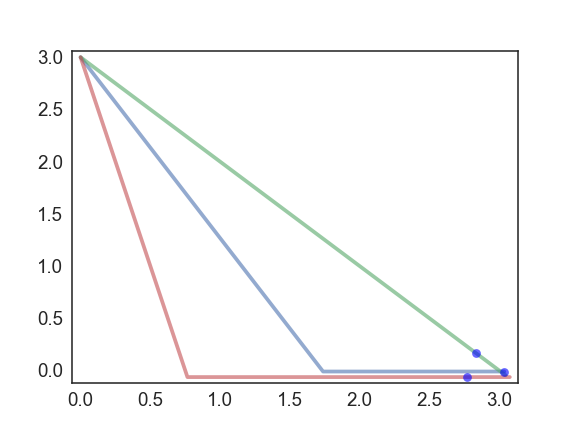

In [60]:
# Plot the result
newfig()
frame0 = system_0.results
frame1 = system_1.results
frame2 = system_2.results
plot(frame0.x, frame0.y, label='system 0 best')
plot(frame1.x, frame1.y, label='system 1 default')
plot(frame2.x, frame2.y, label='system 2')

In [61]:
# Animate 2D
for x0, y0, x1, y1, x2, y2 in zip(frame0.x, frame0.y, frame1.x, frame1.y, frame2.x, frame2.y):
    plot([x0, x1, x2], [y0, y1, y2], 'bo', update=True)
    sleep(system_0.dt)

In [56]:
def sweep_slopes():
    """
    Sweep the values of slopes
    returns: series of total time for each slope
    """
    a_sweep = linspace(-5, -1, 40)
    t_series = SweepSeries()
    for a in a_sweep:
        system = make_system_linear(condition=condition, a=a, b=3)
        # Change dt smaller for more accuracy. Will take more time to run!
        system.dt = 0.0005
        run_simulation(system, update_func)
        t_series[a] = system.t

    return t_series

<IPython.core.display.Javascript object>


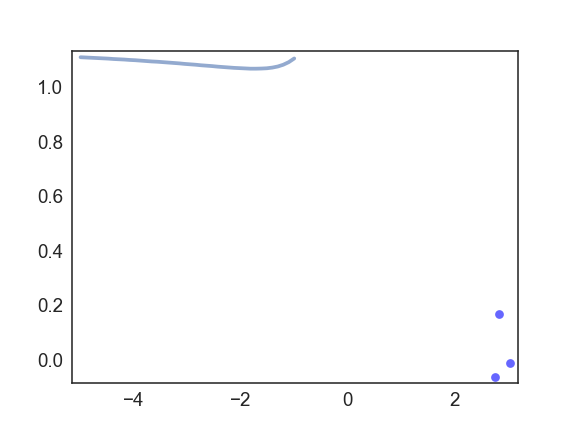

In [57]:
t_series = sweep_slopes()
newfig()
plot(t_series)

In [ ]:
def optimize(t_series):
    T = interpolate(t_series, kind='cubic')
    
    min_time = 1000
    min_a = -5
    a_sweep = linspace(-5, -1, 1000)
    for a in a_sweep:
        temp = T(a)
        if T(a) < min_time:
            min_time = temp
            min_a = a
    
    return min_a, min_time
        
optimize(t_series)

In [ ]:
# Best value from the optimized funtion
system_4 = make_system_linear(condition=condition, a=-1.7287287287287287)
system_4.dt = 0.0001
run_simulation(system_4, update_func)
system_4.t

In [ ]:
# Best value in theory a = -sqrt(3) or the slope makes a 60 degree angle with Ox
# Best value works for all other cases, as long as the slope of line AB <= 60 degree
system_5 = make_system_linear(condition=condition, a=-sqrt(3))
system_5.dt = 0.0001
run_simulation(system_5, update_func)
system_5.t